# Hava Durumu Görüntü Sınıflandırma Projesi 
Bu projede hava durumunu ayırt etmesi için Convolutional Neural Network yani Evrişimsel Sinir Ağları oluşturacağız.
Bunun için Kaggle da bulunan 5-class weather status image classification veri setini kullanacağız.

# Kütüphaneleri İmport Edelim
Gerekli kütüphaneleri import ettik.

In [1]:
!pip install opencv-python

In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


2025-09-25 14:10:38.649025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758809438.858383      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758809438.921184      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Veri Seti Düzenleme
Veri setini düzenleyerek test,train ve validation bölümlerine ayıralım.

In [3]:
import os
import shutil
import random

# Orijinal dataset klasör yolu
original_dataset_dir = '/kaggle/input/5class-weather-status-image-classification/data'  

# Yeni dataset klasörü (train/validation/test olacak)
base_dir = '/kaggle/working/dataset_split'  
os.makedirs(base_dir, exist_ok=True)

# Train/Validation/Test klasörlerini oluştur
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)

    for class_name in os.listdir(original_dataset_dir):
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)

        class_dir = os.path.join(original_dataset_dir, class_name)
        images = os.listdir(class_dir)
        random.shuffle(images)

        # %70 train, %20 validation, %10 test
        train_split = int(0.7 * len(images))
        val_split = int(0.9 * len(images))

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        # Dosyaları kopyala
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_dir, class_name, img))

print("Dataset train/validation/test olarak ayrıldı!")



Dataset train/validation/test olarak ayrıldı!


# Veri Seti İşleme ve Görselleştirme
Veri setini 0-1 arasına çekelim.Sınıfları isimlendirelim ve görsel oluşturalım.

Found 18038 images belonging to 5 classes.
Found 18038 images belonging to 5 classes.
Found 18038 images belonging to 5 classes.

Eğitim verisi: 18038 resim
Doğrulama verisi: 18038 resim
Test verisi: 18038 resim


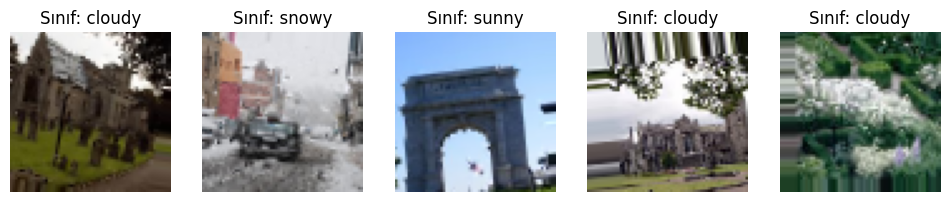

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

print(f"\nEğitim verisi: {train_generator.n} resim")
print(f"Doğrulama verisi: {validation_generator.n} resim")
print(f"Test verisi: {test_generator.n} resim")

# -----------------------------
# Örnek görselleştirme
# -----------------------------
class_names = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
images, labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    class_label_index = np.argmax(labels[i])
    class_label = class_names[class_label_index]
    plt.title(f'Sınıf: {class_label}')
    plt.axis("off")
plt.show()

# Sinir Ağının Oluşturulması
Modelimizin nesnesi oluşturmak için tf.keras.Sequential() kullanacağız.
Katmanları oluşturacağız.(Conv2D (Konvolüsyon Katmanı),MaxPooling2D (Havuzlama Katmanı),Flatten,Dense (Tam Bağlantılı Katman),Dropout)

In [5]:


from tensorflow.keras import Model, Input, layers

inputs = Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1758809576.454245      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758809576.454977      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Modeli Eğitme
Modeli model.fit() ile eğiteceğiz.

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1758809581.388091      92 service.cc:148] XLA service 0x7a7c7800eb00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758809581.389184      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758809581.389205      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758809581.750539      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/141 ━━━━━━━━━━━━━━━━━━━━ 16:50 7s/step - accuracy: 0.1875 - loss: 1.6352

I0000 00:00:1758809585.603157      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 441ms/step - accuracy: 0.5281 - loss: 1.1667 - val_accuracy: 0.6725 - val_loss: 0.8419
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 401ms/step - accuracy: 0.6636 - loss: 0.8706 - val_accuracy: 0.6623 - val_loss: 0.8531
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 396ms/step - accuracy: 0.6836 - loss: 0.8272 - val_accuracy: 0.6951 - val_loss: 0.7972
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 403ms/step - accuracy: 0.6950 - loss: 0.7928 - val_accuracy: 0.7300 - val_loss: 0.7101
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 404ms/step - accuracy: 0.7098 - loss: 0.7566 - val_accuracy: 0.7355 - val_loss: 0.6937
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 401ms/step - accuracy: 0.7204 - loss: 0.7264 - val_accuracy: 0.7387 - val_loss: 0.6775
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 404ms/step - accuracy: 0.7293 - loss: 0.7030 - val_accuracy: 0.7261 - val_loss: 0.7087
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 402ms/step - accuracy: 0.7380 - loss: 0.7012 - val

# Eğitim Sonuçlarını Görselleştirme Ve Doğruluk Payı
Eğitim sonuçlarını grafik ile görselleştirelim ve doğruluk payını hesaplayalım.

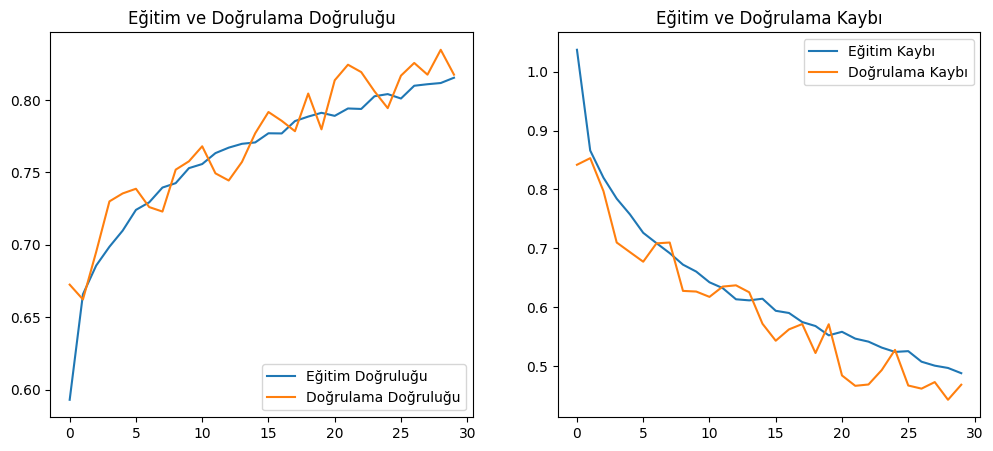

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')

plt.show()


# Performans Değerlendirmesi
Modelin performansını değerlendirelim.

In [8]:
# Tüm test seti üzerinden performans
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=2
)

print(f"Test kaybı: {test_loss:.4f}")
print(f"Test doğruluk: {test_acc*100:.2f}%")


141/141 - 19s - 133ms/step - accuracy: 0.8175 - loss: 0.4688
Test kaybı: 0.4688
Test doğruluk: 81.75%


# Tahmin Denemesi
Model nesnesinde .prediction() metodunu kullanarak deneme yapalım.

In [9]:
# Tek örnek al (test_generator veya image array kullan)
sample_batch, _ = next(test_generator)
sample_image = sample_batch[0:1]  # batch boyutu ekle

# Tahmin yap
pred = model.predict(sample_image)  # output: [[0.1, 0.2, 0.05, 0.6, 0.05]]

# Tahmin edilen sınıf
predicted_class_index = np.argmax(pred, axis=1)[0]

# Tahmin olasılığı
predicted_prob = np.max(pred)

# Sınıf isimleri
class_names = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
predicted_class_name = class_names[predicted_class_index]

print(f"Modelin tahmini sınıfı: {predicted_class_name}")
print(f"Tahmin olasılığı: {predicted_prob*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
Modelin tahmini sınıfı: cloudy
Tahmin olasılığı: 62.05%


# Grad-CAM ile Model Yorumlanabilirliği

In [10]:
# ----------------------------------------------------
# Functional API Model +  Grad-CAM
# ----------------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt
import cv2


inputs = Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ----------------------------------------------------
# Grad-CAM Fonksiyonu
# ----------------------------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    grad_model = Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ----------------------------------------------------
# Heatmap Görselleştirme
# ----------------------------------------------------
def display_gradcam(img_array, heatmap, title="Grad-CAM"):
    img = np.uint8(255 * img_array) if img_array.max() <= 1 else np.uint8(img_array)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.imshow(superimposed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ----------------------------------------------------
#  CLASS_NAMES ve Son Conv Katmanı
# ----------------------------------------------------
# Test generator sınıf sırasını kontrol et
print("Test generator class indices:", test_generator.class_indices)
CLASS_NAMES = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']

LAST_CONV_LAYER_NAME = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        LAST_CONV_LAYER_NAME = layer.name
        break
print("Grad-CAM için kullanılacak katman:", LAST_CONV_LAYER_NAME)

# ----------------------------------------------------
# Modeli Build Et (Dummy Input)
# ----------------------------------------------------
dummy_input = tf.convert_to_tensor(np.expand_dims(test_generator[0][0][0], axis=0), dtype=tf.float32)
_ = model(dummy_input)

# ----------------------------------------------------
#  Grad-CAM Uygulaması (Sadece doğru tahminler)
# ----------------------------------------------------
print("--- Grad-CAM ile Model Yorumlanabilirliği (Doğru Tahminler) ---")
iterator = iter(test_generator)

for batch_num in range(3):
    try:
        images, labels = next(iterator)
    except StopIteration:
        break

    print(f"\n--- Batch {batch_num + 1} İşleniyor ---")
    
    for i in range(min(len(images), 3)):
        img_array = images[i]
        true_index = tf.argmax(labels[i]).numpy()
        true_label = CLASS_NAMES[true_index]
        
        img_for_pred = tf.expand_dims(img_array, axis=0)
        img_for_pred = tf.convert_to_tensor(img_for_pred, dtype=tf.float32)
        predictions = model.predict(img_for_pred, verbose=0)
        predicted_index = np.argmax(predictions[0])
        predicted_label = CLASS_NAMES[predicted_index]

        # ✅ Sadece doğru tahminlerde Grad-CAM göster
        if predicted_index == true_index:
            heatmap = make_gradcam_heatmap(
                img_for_pred, model, LAST_CONV_LAYER_NAME, pred_index=predicted_index
            )
            title = f"Tahmin: {predicted_label.upper()} | Gerçek: {true_label.upper()}"
            print("-" * 30)
            print(f"Görüntü {i+1} | Gerçek: {true_label}, Tahmin: {predicted_label}")
            display_gradcam(img_array, heatmap, title)
        else:
            print(f"Görüntü {i+1} | Yanlış tahmin ({predicted_label} != {true_label}), Grad-CAM atlanıyor.")


Test generator class indices: {'cloudy': 0, 'foggy': 1, 'rainy': 2, 'snowy': 3, 'sunny': 4}
Grad-CAM için kullanılacak katman: conv2d_7
--- Grad-CAM ile Model Yorumlanabilirliği (Doğru Tahminler) ---

--- Batch 1 İşleniyor ---
Görüntü 1 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.
Görüntü 2 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.
Görüntü 3 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.

--- Batch 2 İşleniyor ---
Görüntü 1 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.
Görüntü 2 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.
Görüntü 3 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.

--- Batch 3 İşleniyor ---
Görüntü 1 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.
Görüntü 2 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.
Görüntü 3 | Yanlış tahmin (sunny != cloudy), Grad-CAM atlanıyor.
